In [1]:
from NaiveDataModule import NaiveDataModule, NaiveTEACHDataset
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
from itertools import chain
from collections import Counter
from tqdm import tqdm
import matplotlib.pyplot as plt

DEBUG:matplotlib:matplotlib data path: C:\Users\Pablo\miniconda3\envs\teach\lib\site-packages\matplotlib\mpl-data
DEBUG:matplotlib:CONFIGDIR=C:\Users\Pablo\.matplotlib
DEBUG:matplotlib:interactive is False
DEBUG:matplotlib:platform is win32
DEBUG:matplotlib:loaded modules: ['sys', 'builtins', '_frozen_importlib', '_imp', '_warnings', '_io', 'marshal', 'nt', '_frozen_importlib_external', '_thread', '_weakref', 'winreg', 'time', 'zipimport', '_codecs', 'codecs', 'encodings.aliases', 'encodings', 'encodings.utf_8', 'encodings.cp1252', '_signal', '__main__', 'encodings.latin_1', '_abc', 'abc', 'io', '_stat', 'stat', '_collections_abc', 'genericpath', 'ntpath', 'os.path', 'os', '_sitebuiltins', '_locale', '_bootlocale', '_distutils_hack', 'types', 'importlib._bootstrap', 'importlib._bootstrap_external', 'warnings', 'importlib', 'importlib.machinery', 'importlib.abc', '_operator', 'operator', 'keyword', '_heapq', 'heapq', 'itertools', 'reprlib', '_collections', 'collections', '_functools', '

DEBUG:matplotlib:CACHEDIR=C:\Users\Pablo\.matplotlib
DEBUG:matplotlib.font_manager:Using fontManager instance from C:\Users\Pablo\.matplotlib\fontlist-v330.json


In [9]:
parent_dir_path = "E:"
data_parent_dir_path = os.path.join(parent_dir_path, 'teach-dataset')
w2v_path = os.path.join(parent_dir_path, 'GoogleNews-vectors-negative300.bin.gz')

## Plot actions Distribution on EDH

In [10]:
naive_datamodule = NaiveDataModule(
    data_parent_dir_path, 
    w2v_path, 
    16, 
    x_text_pad_length=1024, 
    use_small_dataset=False,
    num_workers=4,
    include_x_cur_image=False,
    include_x_prev_actions=False
)

In [11]:
naive_datamodule.setup("train")

[MainThread-10268-INFO] NaiveDataModule: Loading dataset for stage train


INFO:NaiveDataModule:Loading dataset for stage train
INFO:gensim.models.keyedvectors:loading projection weights from E:GoogleNews-vectors-negative300.bin.gz
DEBUG:smart_open.smart_open_lib:{'uri': 'E:GoogleNews-vectors-negative300.bin.gz', 'mode': 'rb', 'buffering': -1, 'encoding': None, 'errors': None, 'newline': None, 'closefd': True, 'opener': None, 'compression': 'infer_from_extension', 'transport_params': None}
DEBUG:gensim.utils:starting a new internal lifecycle event log for KeyedVectors
INFO:gensim.utils:KeyedVectors lifecycle event {'msg': 'loaded (100000, 300) matrix of type float32 from E:GoogleNews-vectors-negative300.bin.gz', 'binary': True, 'encoding': 'utf8', 'datetime': '2022-05-04T22:49:06.058734', 'gensim': '4.1.2', 'python': '3.8.13 (default, Mar 28 2022, 06:59:08) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22000-SP0', 'event': 'load_word2vec_format'}
100%|████████████████████████████████████████████████████████████████████████████████████████████████

In [12]:
naive_datamodule.setup("val")

[MainThread-10268-INFO] NaiveDataModule: Loading dataset for stage val


INFO:NaiveDataModule:Loading dataset for stage val
INFO:gensim.models.keyedvectors:loading projection weights from E:GoogleNews-vectors-negative300.bin.gz
DEBUG:smart_open.smart_open_lib:{'uri': 'E:GoogleNews-vectors-negative300.bin.gz', 'mode': 'rb', 'buffering': -1, 'encoding': None, 'errors': None, 'newline': None, 'closefd': True, 'opener': None, 'compression': 'infer_from_extension', 'transport_params': None}
DEBUG:gensim.utils:starting a new internal lifecycle event log for KeyedVectors
INFO:gensim.utils:KeyedVectors lifecycle event {'msg': 'loaded (100000, 300) matrix of type float32 from E:GoogleNews-vectors-negative300.bin.gz', 'binary': True, 'encoding': 'utf8', 'datetime': '2022-05-04T22:49:30.545603', 'gensim': '4.1.2', 'python': '3.8.13 (default, Mar 28 2022, 06:59:08) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22000-SP0', 'event': 'load_word2vec_format'}
100%|██████████████████████████████████████████████████████████████████████████████████████████████████

In [13]:
naive_datamodule.setup("val_unseen")

[MainThread-10268-INFO] NaiveDataModule: Loading dataset for stage val_unseen


INFO:NaiveDataModule:Loading dataset for stage val_unseen
INFO:gensim.models.keyedvectors:loading projection weights from E:GoogleNews-vectors-negative300.bin.gz
DEBUG:smart_open.smart_open_lib:{'uri': 'E:GoogleNews-vectors-negative300.bin.gz', 'mode': 'rb', 'buffering': -1, 'encoding': None, 'errors': None, 'newline': None, 'closefd': True, 'opener': None, 'compression': 'infer_from_extension', 'transport_params': None}
DEBUG:gensim.utils:starting a new internal lifecycle event log for KeyedVectors
INFO:gensim.utils:KeyedVectors lifecycle event {'msg': 'loaded (100000, 300) matrix of type float32 from E:GoogleNews-vectors-negative300.bin.gz', 'binary': True, 'encoding': 'utf8', 'datetime': '2022-05-04T22:49:34.080578', 'gensim': '4.1.2', 'python': '3.8.13 (default, Mar 28 2022, 06:59:08) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22000-SP0', 'event': 'load_word2vec_format'}
100%|███████████████████████████████████████████████████████████████████████████████████████████

In [14]:
all_agent_actions = [
    "Stop","Forward","Backward","Turn Left","Turn Right","Look Up","Look Down","Pan Left","Pan Right","Pickup","Place",
    "Open","Close","ToggleOn","ToggleOff","Slice", "Pour"
]
navigation_actions = set(["Forward","Backward","Turn Left","Turn Right","Look Up","Look Down","Pan Left","Pan Right"])
interaction_actions = set(["Pickup","Place","Open","Close","ToggleOn","ToggleOff","Slice", "Pour"])

In [15]:
def action_one_hot_to_name(onehot_tensor):
    return all_agent_actions[onehot_tensor.argmax()]

In [16]:
action_counts = Counter()
navigation_actions_count = Counter()
interaction_actions_count = Counter()

In [17]:
naive_dls = [
    iter(naive_datamodule.train_dataloader()), 
    iter(naive_datamodule.val_dataloader()),
    iter(naive_datamodule.val_unseen_dataloader())
]

In [18]:
for _, batched_y in tqdm(chain(*naive_dls)):
    for i in range(batched_y.size(0)):
        action_name = action_one_hot_to_name(batched_y[i])
        action_counts[action_name] += 1
        if action_name in navigation_actions:
            navigation_actions_count[action_name] += 1
        if action_name in interaction_actions:
            interaction_actions_count[action_name] += 1

37204it [01:16, 485.24it/s]


In [19]:
action_counts

Counter({'Forward': 222615,
         'Turn Left': 39308,
         'Turn Right': 54014,
         'Pan Left': 76523,
         'Pickup': 37747,
         'Place': 34631,
         'ToggleOn': 5524,
         'ToggleOff': 6969,
         'Pour': 1949,
         'Pan Right': 67791,
         'Look Up': 3757,
         'Look Down': 3185,
         'Slice': 6416,
         'Backward': 18838,
         'Open': 9742,
         'Close': 6248})

In [20]:
navigation_actions_count

Counter({'Forward': 222615,
         'Turn Left': 39308,
         'Turn Right': 54014,
         'Pan Left': 76523,
         'Pan Right': 67791,
         'Look Up': 3757,
         'Look Down': 3185,
         'Backward': 18838})

In [21]:
interaction_actions_count

Counter({'Pickup': 37747,
         'Place': 34631,
         'ToggleOn': 5524,
         'ToggleOff': 6969,
         'Pour': 1949,
         'Slice': 6416,
         'Open': 9742,
         'Close': 6248})

In [22]:
sum(interaction_actions_count.values())

109226

In [23]:
sum(navigation_actions_count.values())

486031

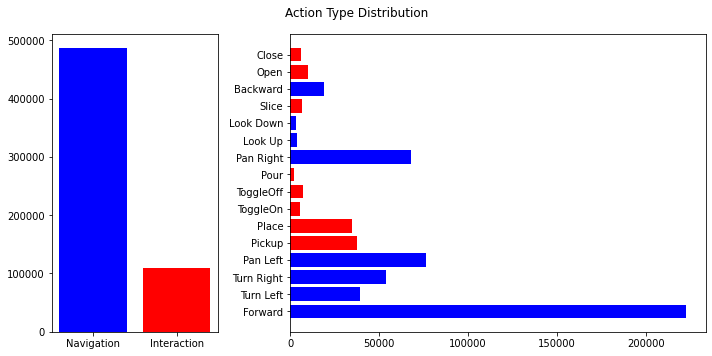

In [58]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), gridspec_kw={'width_ratios': [2, 5]})
counts = [sum(navigation_actions_count.values()), sum(interaction_actions_count.values())]
labels = ['Navigation', 'Interaction']
colors = ['blue', 'red']
ax1.bar(labels, counts, color=colors)
counts = list(action_counts.values())
labels = list(action_counts.keys())
colors = ['blue' if action in navigation_actions else 'red' for action in action_counts.keys()]
ax2.barh(labels, counts, color=colors)
fig.suptitle("Action Type Distribution")
plt.subplots_adjust(wspace=0.2)
fig.tight_layout()
plt.savefig("action_dist.png")

# Task Dataset

In [59]:
from TaskFromDialogueHistoryDataModule import TaskFromDialogueHistoryDataModule, TaskFromDialogueHistoryTEACHDataset

In [60]:
single_rt_datamodule = TaskFromDialogueHistoryDataModule(
    data_parent_dir_path,
    use_commander_language = True,
    use_follower_language = True,
    use_main_task_only=True,
    use_edh=False
)

DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): huggingface.co:443
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /distilbert-base-uncased/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): huggingface.co:443
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /distilbert-base-uncased/resolve/main/config.json HTTP/1.1" 200 0
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): huggingface.co:443
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /distilbert-base-uncased/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): huggingface.co:443
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /distilbert-base-uncased/resolve/main/vocab.txt HTTP/1.1" 200 0
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): huggingface.co:443
DEBUG:urllib3.connectionpool:https://huggingface.co:443

In [61]:
single_rt_datamodule.setup("train")

[MainThread-10268-INFO] TaskFromDialogueHistoryDataModule: Loading dataset for stage train


INFO:TaskFromDialogueHistoryDataModule:Loading dataset for stage train
  0%|                                                                                                                                                                                                                                                                                                                                    | 0/5475 [00:00<?, ?it/s]

[MainThread-10268-INFO] TaskFromDialogueHistoryDataModule: Added new task (id: 301) 'Breakfast' as class #0


INFO:TaskFromDialogueHistoryDataModule:Added new task (id: 301) 'Breakfast' as class #0


[MainThread-10268-INFO] TaskFromDialogueHistoryDataModule: Added new task (id: 303) 'Salad' as class #1


INFO:TaskFromDialogueHistoryDataModule:Added new task (id: 303) 'Salad' as class #1
  0%|▊                                                                                                                                                                                                                                                                                                                         | 14/5475 [00:00<00:43, 125.97it/s]

[MainThread-10268-INFO] TaskFromDialogueHistoryDataModule: Added new task (id: 107) 'N Cooked Slices Of X In Y' as class #2


INFO:TaskFromDialogueHistoryDataModule:Added new task (id: 107) 'N Cooked Slices Of X In Y' as class #2


[MainThread-10268-INFO] TaskFromDialogueHistoryDataModule: Added new task (id: 110) 'Put All X On Y' as class #3


INFO:TaskFromDialogueHistoryDataModule:Added new task (id: 110) 'Put All X On Y' as class #3


[MainThread-10268-INFO] TaskFromDialogueHistoryDataModule: Added new task (id: 102) 'Coffee' as class #4


INFO:TaskFromDialogueHistoryDataModule:Added new task (id: 102) 'Coffee' as class #4
  1%|██▌                                                                                                                                                                                                                                                                                                                       | 44/5475 [00:00<00:24, 219.42it/s]

[MainThread-10268-INFO] TaskFromDialogueHistoryDataModule: Added new task (id: 111) 'Put All X In One Y' as class #5


INFO:TaskFromDialogueHistoryDataModule:Added new task (id: 111) 'Put All X In One Y' as class #5


[MainThread-10268-INFO] TaskFromDialogueHistoryDataModule: Added new task (id: 112) 'Boil X' as class #6


INFO:TaskFromDialogueHistoryDataModule:Added new task (id: 112) 'Boil X' as class #6


[MainThread-10268-INFO] TaskFromDialogueHistoryDataModule: Added new task (id: 115) 'Clean All X' as class #7


INFO:TaskFromDialogueHistoryDataModule:Added new task (id: 115) 'Clean All X' as class #7
  1%|███▊                                                                                                                                                                                                                                                                                                                      | 67/5475 [00:00<00:28, 190.26it/s]

[MainThread-10268-INFO] TaskFromDialogueHistoryDataModule: Added new task (id: 106) 'Plate Of Toast' as class #8


INFO:TaskFromDialogueHistoryDataModule:Added new task (id: 106) 'Plate Of Toast' as class #8


[MainThread-10268-INFO] TaskFromDialogueHistoryDataModule: Added new task (id: 302) 'Sandwich' as class #9


INFO:TaskFromDialogueHistoryDataModule:Added new task (id: 302) 'Sandwich' as class #9
  4%|████████████▉                                                                                                                                                                                                                                                                                                            | 227/5475 [00:01<00:36, 143.13it/s]

[MainThread-10268-INFO] TaskFromDialogueHistoryDataModule: Added new task (id: 108) 'N Slices Of X In Y' as class #10


INFO:TaskFromDialogueHistoryDataModule:Added new task (id: 108) 'N Slices Of X In Y' as class #10
  6%|██████████████████▏                                                                                                                                                                                                                                                                                                      | 318/5475 [00:02<00:32, 157.19it/s]

[MainThread-10268-INFO] TaskFromDialogueHistoryDataModule: Added new task (id: 114) 'Water Plant' as class #11


INFO:TaskFromDialogueHistoryDataModule:Added new task (id: 114) 'Water Plant' as class #11
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5475/5475 [00:37<00:00, 147.73it/s]


In [62]:
multi_rt_datamodule = TaskFromDialogueHistoryDataModule(
    data_parent_dir_path,
    use_commander_language = True,
    use_follower_language = True,
    use_main_task_only=False,
    use_edh=False
)

DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): huggingface.co:443
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /distilbert-base-uncased/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): huggingface.co:443
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /distilbert-base-uncased/resolve/main/config.json HTTP/1.1" 200 0
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): huggingface.co:443
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /distilbert-base-uncased/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): huggingface.co:443
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /distilbert-base-uncased/resolve/main/vocab.txt HTTP/1.1" 200 0
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): huggingface.co:443
DEBUG:urllib3.connectionpool:https://huggingface.co:443

In [63]:
multi_rt_datamodule.setup("train")

[MainThread-10268-INFO] TaskFromDialogueHistoryDataModule: Loading dataset for stage train


INFO:TaskFromDialogueHistoryDataModule:Loading dataset for stage train
  0%|                                                                                                                                                                                                                                                                                                                                    | 0/5475 [00:00<?, ?it/s]

[MainThread-10268-INFO] TaskFromDialogueHistoryDataModule: Added new task (id: 301) 'Breakfast' as class #0


INFO:TaskFromDialogueHistoryDataModule:Added new task (id: 301) 'Breakfast' as class #0


[MainThread-10268-INFO] TaskFromDialogueHistoryDataModule: Added new task (id: 102) 'Coffee' as class #1


INFO:TaskFromDialogueHistoryDataModule:Added new task (id: 102) 'Coffee' as class #1


[MainThread-10268-INFO] TaskFromDialogueHistoryDataModule: Added new task (id: 106) 'Plate Of Toast' as class #2


INFO:TaskFromDialogueHistoryDataModule:Added new task (id: 106) 'Plate Of Toast' as class #2


[MainThread-10268-INFO] TaskFromDialogueHistoryDataModule: Added new task (id: 101) 'Toast' as class #3


INFO:TaskFromDialogueHistoryDataModule:Added new task (id: 101) 'Toast' as class #3


[MainThread-10268-INFO] TaskFromDialogueHistoryDataModule: Added new task (id: 103) 'Clean X' as class #4


INFO:TaskFromDialogueHistoryDataModule:Added new task (id: 103) 'Clean X' as class #4


[MainThread-10268-INFO] TaskFromDialogueHistoryDataModule: Added new task (id: 107) 'N Cooked Slices Of X In Y' as class #5


INFO:TaskFromDialogueHistoryDataModule:Added new task (id: 107) 'N Cooked Slices Of X In Y' as class #5


[MainThread-10268-INFO] TaskFromDialogueHistoryDataModule: Added new task (id: 105) 'Cooked Slice Of X' as class #6


INFO:TaskFromDialogueHistoryDataModule:Added new task (id: 105) 'Cooked Slice Of X' as class #6


[MainThread-10268-INFO] TaskFromDialogueHistoryDataModule: Added new task (id: 108) 'N Slices Of X In Y' as class #7


INFO:TaskFromDialogueHistoryDataModule:Added new task (id: 108) 'N Slices Of X In Y' as class #7


[MainThread-10268-INFO] TaskFromDialogueHistoryDataModule: Added new task (id: 104) 'Sliced X' as class #8


INFO:TaskFromDialogueHistoryDataModule:Added new task (id: 104) 'Sliced X' as class #8


[MainThread-10268-INFO] TaskFromDialogueHistoryDataModule: Added new task (id: 302) 'Sandwich' as class #9


INFO:TaskFromDialogueHistoryDataModule:Added new task (id: 302) 'Sandwich' as class #9


[MainThread-10268-INFO] TaskFromDialogueHistoryDataModule: Added new task (id: 303) 'Salad' as class #10


INFO:TaskFromDialogueHistoryDataModule:Added new task (id: 303) 'Salad' as class #10
  0%|█▍                                                                                                                                                                                                                                                                                                                        | 26/5475 [00:00<00:20, 259.99it/s]

[MainThread-10268-INFO] TaskFromDialogueHistoryDataModule: Added new task (id: 110) 'Put All X On Y' as class #11


INFO:TaskFromDialogueHistoryDataModule:Added new task (id: 110) 'Put All X On Y' as class #11


[MainThread-10268-INFO] TaskFromDialogueHistoryDataModule: Added new task (id: 111) 'Put All X In One Y' as class #12


INFO:TaskFromDialogueHistoryDataModule:Added new task (id: 111) 'Put All X In One Y' as class #12


[MainThread-10268-INFO] TaskFromDialogueHistoryDataModule: Added new task (id: 112) 'Boil X' as class #13


INFO:TaskFromDialogueHistoryDataModule:Added new task (id: 112) 'Boil X' as class #13
  1%|███▎                                                                                                                                                                                                                                                                                                                      | 58/5475 [00:00<00:18, 295.28it/s]

[MainThread-10268-INFO] TaskFromDialogueHistoryDataModule: Added new task (id: 115) 'Clean All X' as class #14


INFO:TaskFromDialogueHistoryDataModule:Added new task (id: 115) 'Clean All X' as class #14
  6%|██████████████████▉                                                                                                                                                                                                                                                                                                      | 331/5475 [00:01<00:24, 214.10it/s]

[MainThread-10268-INFO] TaskFromDialogueHistoryDataModule: Added new task (id: 114) 'Water Plant' as class #15


INFO:TaskFromDialogueHistoryDataModule:Added new task (id: 114) 'Water Plant' as class #15
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5475/5475 [00:20<00:00, 270.53it/s]
